# Breast Cancer Classification using SVM and VGG feature extraction (balanced data)

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
import os, shutil
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


### Instantiate convolutional base

In [2]:
img_width = 224
img_height = 224

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [3]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Load data

In [4]:
batch_size = 8

def loading(HEIGHT = img_height, WIDTH = img_width,
BATCH_SIZE = batch_size, VALIDATION_SPLIT = 0.3,
ROT_RANGE = 90, H_FLIP = True, SHEAR_RANGE = 0.2,
ZOOM_RANGE = 0.2, V_FLIP = True):

    TRAIN_DIR = "C:/Users/Abdullah Abid/Desktop/Project/BreakHis Data 2"
    train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=ROT_RANGE,
    horizontal_flip=H_FLIP,
    shear_range=SHEAR_RANGE,
    zoom_range =ZOOM_RANGE,
    vertical_flip=V_FLIP,
    validation_split=VALIDATION_SPLIT
    )

    train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    subset = 'training',
                                                    class_mode='sparse')
    validation_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                        target_size = (HEIGHT, WIDTH),
                                                        batch_size=BATCH_SIZE,
                                                        subset = 'validation',
                                                        class_mode='sparse')
    return train_generator, validation_generator

In [5]:
%%time
train_generator, validation_generator = loading()

Found 5600 images belonging to 8 classes.
Found 2400 images belonging to 8 classes.
Wall time: 557 ms


### Extract features

In [6]:
# code reference: https://github.com/pmarcelino/blog/blob/master/dogs_cats/dogs_cats.ipynb

def extract_features(sample_count, generator):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

In [7]:
%%time
train_features, train_labels = extract_features(train_generator.n, train_generator)
validation_features, validation_labels = extract_features(validation_generator.n, validation_generator)


Wall time: 57min 21s


### SVM classifier

In [8]:
%%time

X_train, y_train = train_features.reshape(train_generator.n, 7*7*512), train_labels
X_test, y_test = validation_features.reshape(validation_generator.n, 7*7*512), validation_labels

params = [{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100]},
          {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]},
          {'kernel': ['poly'], 'C': [0.01, 0.1, 1, 10, 100]}]

svc = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf = GridSearchCV(svc, params, iid='False', cv=5)
clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 2min 16s


In [7]:
clf.best_params_

{'C': 1, 'kernel': 'rbf'}

In [9]:
%%time
y_pred = clf.predict(X_test)

Wall time: 457 ms


### Classification report

In [10]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.56      0.55       300
         1.0       0.27      0.29      0.28       300
         2.0       0.27      0.43      0.33       300
         3.0       0.45      0.33      0.38       300
         4.0       0.20      0.09      0.13       300
         5.0       0.30      0.31      0.30       300
         6.0       0.25      0.29      0.27       300
         7.0       0.35      0.32      0.33       300

    accuracy                           0.33      2400
   macro avg       0.33      0.33      0.32      2400
weighted avg       0.33      0.33      0.32      2400



### Confusion matrix

In [11]:
# code reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [14]:
class_names = []

for key in train_generator.class_indices.keys():
    class_names.append(key)

class_names = np.array(class_names)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

Confusion matrix, without normalization
[[168   3  27  23   6  11  44  18]
 [ 21  88  22  50  29  45  24  21]
 [ 20   3 129   8   7  20 100  13]
 [  8 103  12  99   8  37  20  13]
 [ 36  83  28  26  28  33  23  43]
 [ 17  32  40   8  48  92  14  49]
 [  7   6 133   4   4  37  86  23]
 [ 39   6  83   2  10  29  35  96]]


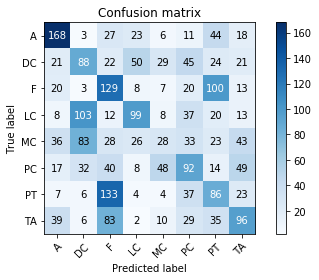

In [15]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix')
plt.show()

Normalized confusion matrix
[[0.56 0.01 0.09 0.08 0.02 0.04 0.15 0.06]
 [0.07 0.29 0.07 0.17 0.1  0.15 0.08 0.07]
 [0.07 0.01 0.43 0.03 0.02 0.07 0.33 0.04]
 [0.03 0.34 0.04 0.33 0.03 0.12 0.07 0.04]
 [0.12 0.28 0.09 0.09 0.09 0.11 0.08 0.14]
 [0.06 0.11 0.13 0.03 0.16 0.31 0.05 0.16]
 [0.02 0.02 0.44 0.01 0.01 0.12 0.29 0.08]
 [0.13 0.02 0.28 0.01 0.03 0.1  0.12 0.32]]


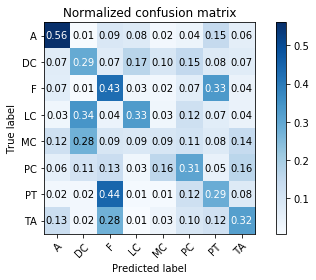

In [16]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Learning curve 

Wall time: 4h 58min 42s


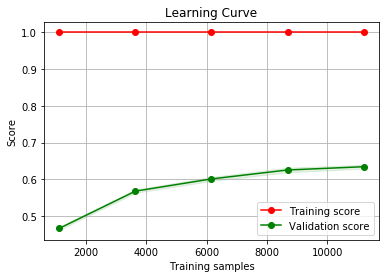

In [11]:
%%time

import warnings
warnings.filterwarnings('ignore')

# code reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training samples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validation score")

plt.legend(loc="best")